In [1]:
accepted_categories = ["dress", "high_heel", "handbag", "skirt", "outerwear", "boot"]
label2id = {
    "dress": 0,
    "high_heel": 1, 
    "handbag": 2,
    "skirt": 3, 
    "outerwear": 4, 
    "boot": 5
    
}
id2label = {
    0: "dress",
    1: "high_heel", 
    2: "handbag",
    3: "skirt", 
    4: "outerwear", 
    5: "boot"
}

RANDOM_STATE = 12345

In [2]:
import os
import pandas as pd

CATEGORY_KEYWORDS = {
    "dresses": "dress",
    "skirts": "skirt",
    "boots": "boot",
    "coat": "outerwear",
    "coats": "outerwear",
    "outerwear": "outerwear",
    "bag": "handbag",
    "bags": "handbag",
    "high-heels": "high_heel",
    "high_heels": "high_heel",
    "heels": "high_heel",
}

def categorize_image(url: str) -> str:
    filename = os.path.basename(url).lower()
    for keyword, category in CATEGORY_KEYWORDS.items():
        if keyword in filename:
            return category
    return "other"

In [28]:
information_dataframe = pd.read_csv("../slowfashion/information.csv")
information_dataframe["global_category"] = information_dataframe["path"].apply(categorize_image)
information_dataframe["label_id"] = information_dataframe["global_category"].apply(lambda item: label2id[item] if item in label2id else -1)

In [29]:
information_dataframe.groupby("global_category").size()

global_category
boot           47
dress         212
handbag       135
high_heel     130
other        2142
outerwear     247
skirt          95
dtype: int64

In [30]:
information_dataframe.groupby("type").size()

type
BACK              304
FIRST DETAIL      284
FRONT             535
LABEL             304
OTHER            1374
SECOND DETAIL     207
dtype: int64

In [31]:
other_dataframe = information_dataframe[information_dataframe["global_category"] == "other"]
information_dataframe=information_dataframe[information_dataframe["global_category"] != "other"]
full_dataframe = information_dataframe.copy()
full_dataframe = full_dataframe[~information_dataframe["type"].isin(["FIRST DETAIL", "SECOND DETAIL", "LABEL"])]
information_dataframe = information_dataframe[information_dataframe["type"].isin(["FRONT", "BACK"])]

In [32]:
information_dataframe.shape

(209, 4)

In [33]:
information_dataframe.groupby("global_category").size()

global_category
boot          9
dress        63
handbag      26
high_heel    25
outerwear    56
skirt        30
dtype: int64

In [34]:
#information_dataframe.query("label_id == -1")["path"].apply(lambda item: item.split("/")[-1]).unique()

In [35]:
#information_dataframe[information_dataframe["path"].str.lower().str.contains("dress")].groupby("global_category").size()

# Validation

In [36]:
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def decode_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0  # Normalizar
    return image, label

def prepare_dataset(df, shuffle=True):
    paths = df["path"].values
    labels = df["label_id"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=20_000)  # optimize memory
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    #ds = ds.repeat()
    ds = ds.apply(tf.data.experimental.ignore_errors())
    return ds

val_ds = prepare_dataset(information_dataframe, shuffle=True)
full_val_ds = prepare_dataset(full_dataframe, shuffle=True)
other_val_ds = prepare_dataset(other_dataframe, shuffle=True)

In [37]:
import tensorflow as tf

IMG_SIZE_2 = 248
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def decode_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE_2, IMG_SIZE_2])
    image = image / 255.0  # Normalizar
    return image, label

def prepare_dataset(df, shuffle=True):
    paths = df["path"].values
    labels = df["label_id"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=20_000)  # optimize memory
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    #ds = ds.repeat()
    ds = ds.apply(tf.data.experimental.ignore_errors())
    return ds


val_248_ds = prepare_dataset(information_dataframe, shuffle=True)
full_val_248_ds = prepare_dataset(full_dataframe, shuffle=True)
other_val_248_ds = prepare_dataset(other_dataframe, shuffle=True)

In [13]:
from utils.performance import plot_top3_predictions, evaluate_and_save_metrics, plot_random_images_per_category

In [14]:
from tensorflow.keras.models import load_model

def load_trained_model(model_path):
    """
    Loads a Keras model from the specified file path.

    Parameters:
    - model_path (str): Path to the saved model file (e.g., .h5 or .keras)

    Returns:
    - model (tf.keras.Model): The loaded model
    """
    model = load_model(model_path)
    print(f"✅ Model loaded from: {model_path}")
    return model


In [15]:
mobile_tl_model = load_trained_model("models/model_mobilenet_tl/best_model.h5")
efficient_tl_model = load_trained_model("models/efficient_net_tl/best_model.h5")

mobile_from_zero_model = load_trained_model("models/from_zero_mobile_net//best_model.h5")
efficient_from_zero_model = load_trained_model("models/from_zero_efficient_net//best_model.h5")

✅ Model loaded from: models/model_mobilenet_tl/best_model.h5


✅ Model loaded from: models/efficient_net_tl/best_model.h5


✅ Model loaded from: models/from_zero_mobile_net//best_model.h5


✅ Model loaded from: models/from_zero_efficient_net//best_model.h5


In [16]:
evaluate_and_save_metrics(mobile_tl_model, val_ds, id2label, output_folder="results/mobile_net_tl/")

I0000 00:00:1747599309.258304   43584 service.cc:152] XLA service 0x7f4604121f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747599309.258334   43584 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-05-18 22:15:09.272293: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747599309.457430   43584 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-18 22:15:09.993811: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_661', 80 bytes spill stores, 120 bytes spill loads

2025-05-18 22:15:10.171928: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_66


✅ Accuracy:     0.7321
🎯 Top-2 Acc:    0.8756
🎯 Top-3 Acc:    0.9282

📊 Per-class metrics:

dress            Count: 63    Precision: 1.0000  Recall: 0.5079  F1: 0.6737
high_heel        Count: 25    Precision: 0.9375  Recall: 0.6000  F1: 0.7317
handbag          Count: 26    Precision: 0.5581  Recall: 0.9231  F1: 0.6957
skirt            Count: 30    Precision: 0.9032  Recall: 0.9333  F1: 0.9180
outerwear        Count: 56    Precision: 0.7077  Recall: 0.8214  F1: 0.7603
boot             Count: 9     Precision: 0.3636  Recall: 0.8889  F1: 0.5161

📁 Report saved to: results/mobile_net_tl/classification_report.xlsx


In [17]:
evaluate_and_save_metrics(efficient_tl_model, val_248_ds, id2label, output_folder="results/efficient_tl/")

2025-05-18 22:15:18.773272: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2279', 4 bytes spill stores, 4 bytes spill loads

2025-05-18 22:15:18.809354: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2279', 60 bytes spill stores, 60 bytes spill loads

2025-05-18 22:15:19.023035: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2279', 948 bytes spill stores, 948 bytes spill loads

2025-05-18 22:15:19.156872: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2279', 1180 bytes spill stores, 1244 bytes spill loads

2025-05-18 22:15:25.367605: I extern


✅ Accuracy:     0.2727
🎯 Top-2 Acc:    0.4115
🎯 Top-3 Acc:    0.6555

📊 Per-class metrics:

dress            Count: 63    Precision: 0.0000  Recall: 0.0000  F1: 0.0000
high_heel        Count: 25    Precision: 0.2500  Recall: 0.2000  F1: 0.2222
handbag          Count: 26    Precision: 0.0000  Recall: 0.0000  F1: 0.0000
skirt            Count: 30    Precision: 0.3548  Recall: 0.3667  F1: 0.3607
outerwear        Count: 56    Precision: 0.2697  Recall: 0.7321  F1: 0.3942
boot             Count: 9     Precision: 0.0000  Recall: 0.0000  F1: 0.0000

📁 Report saved to: results/efficient_tl/classification_report.xlsx


2025-05-18 22:15:28.890457: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
evaluate_and_save_metrics(mobile_from_zero_model, val_248_ds, id2label, output_folder="results/mobile_from_zero/")

2025-05-18 22:15:30.045973: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-18 22:15:30.188788: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-18 22:15:30.320262: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2025-05-18 22:15:33.088579: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-18 22:15:33.215376: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



✅ Accuracy:     0.1962
🎯 Top-2 Acc:    0.4163
🎯 Top-3 Acc:    0.6507

📊 Per-class metrics:

dress            Count: 63    Precision: 0.2759  Recall: 0.2540  F1: 0.2645
high_heel        Count: 25    Precision: 0.1250  Recall: 0.1200  F1: 0.1224
handbag          Count: 26    Precision: 0.2500  Recall: 0.0385  F1: 0.0667
skirt            Count: 30    Precision: 0.1707  Recall: 0.4667  F1: 0.2500
outerwear        Count: 56    Precision: 0.1842  Recall: 0.1250  F1: 0.1489
boot             Count: 9     Precision: 0.0000  Recall: 0.0000  F1: 0.0000

📁 Report saved to: results/mobile_from_zero/classification_report.xlsx


In [19]:
evaluate_and_save_metrics(efficient_from_zero_model, val_248_ds, id2label, output_folder="results/efficient_from_zero/")


✅ Accuracy:     0.1100
🎯 Top-2 Acc:    0.2488
🎯 Top-3 Acc:    0.3923

📊 Per-class metrics:

dress            Count: 63    Precision: 0.0000  Recall: 0.0000  F1: 0.0000
high_heel        Count: 25    Precision: 0.1364  Recall: 0.3600  F1: 0.1978
handbag          Count: 26    Precision: 0.0645  Recall: 0.2308  F1: 0.1008
skirt            Count: 30    Precision: 0.1064  Recall: 0.1667  F1: 0.1299
outerwear        Count: 56    Precision: 1.0000  Recall: 0.0536  F1: 0.1017
boot             Count: 9     Precision: 0.0000  Recall: 0.0000  F1: 0.0000

📁 Report saved to: results/efficient_from_zero/classification_report.xlsx


2025-05-18 22:15:41.647573: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Sample

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


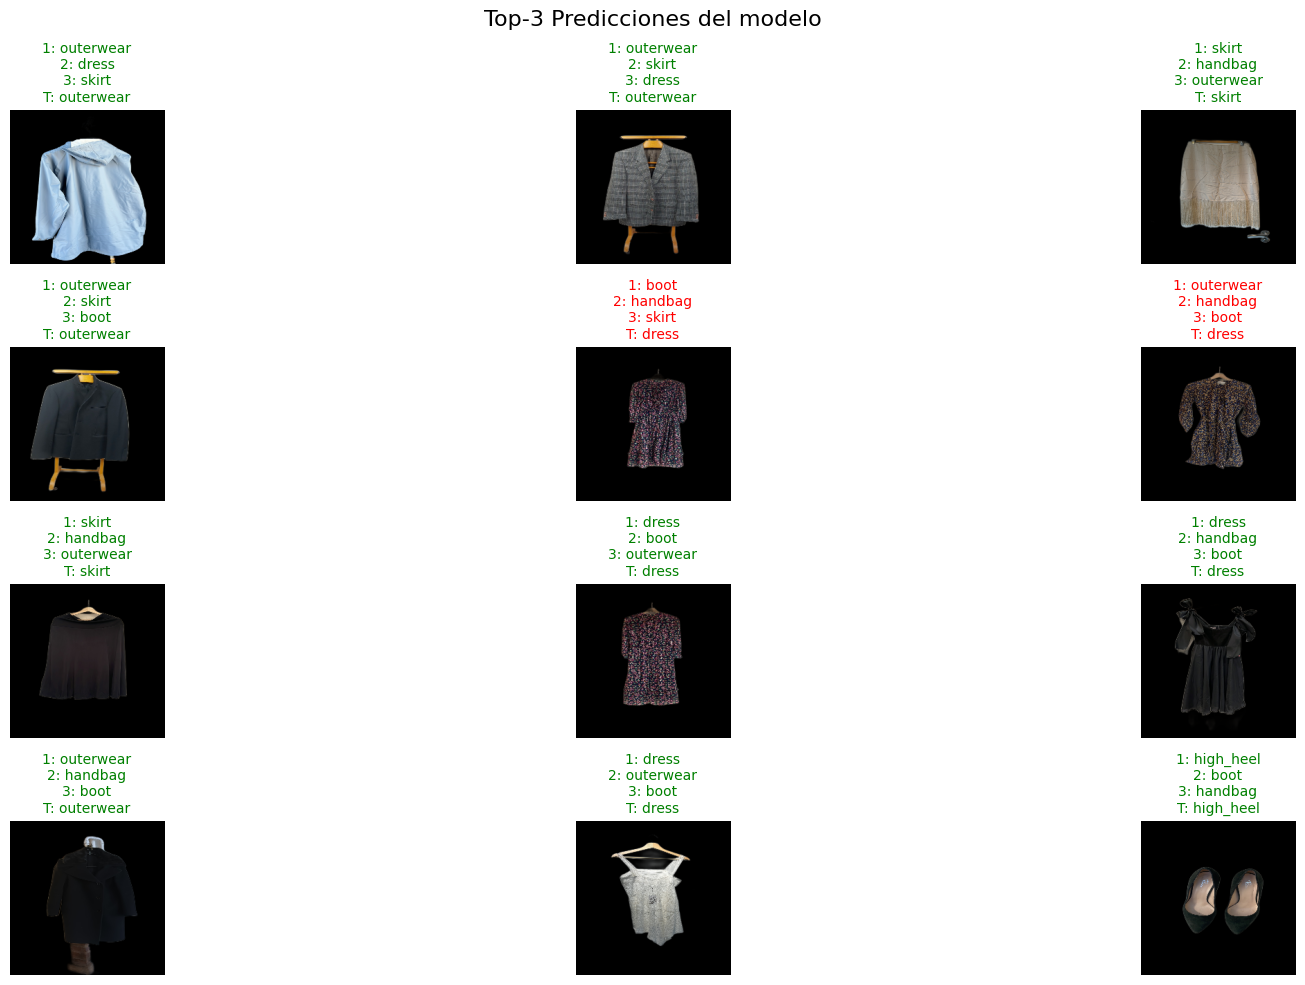

In [20]:
plot_top3_predictions(mobile_tl_model, val_ds, id2label, rows=4, cols=3)

In [21]:
from utils.performance import compare_models_metrics
model_list = [
    ("mobile_tl_model", mobile_tl_model,0),
    ("efficient_tl_model", efficient_tl_model,1),
    ("mobile_from_zero_model", mobile_from_zero_model,1),
    ("efficient_from_zero_model", efficient_from_zero_model,1),
]
df_summary, df_detailed = compare_models_metrics(model_list, [val_ds, val_248_ds], id2label, "results/summary/")


📁 Report saved to: results/summary/models_comparison_report.xlsx


2025-05-18 22:15:45.013617: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
df_summary

,model,accuracy,top_2_accuracy,top_3_accuracy
0,mobile_tl_model,0.732057,0.875598,0.928230
1,efficient_tl_model,0.272727,0.411483,0.655502
2,mobile_from_zero_model,0.196172,0.416268,0.650718
3,efficient_from_zero_model,0.110048,0.248804,0.392345


In [23]:
df_detailed

,model,class_id,class_name,count,precision,recall,f1_score
0,mobile_tl_model,0,dress,63,1.000000,0.507937,0.673684
1,mobile_tl_model,1,high_heel,25,0.937500,0.600000,0.731707
2,mobile_tl_model,2,handbag,26,0.558140,0.923077,0.695652
3,mobile_tl_model,3,skirt,30,0.903226,0.933333,0.918033
4,mobile_tl_model,4,outerwear,56,0.707692,0.821429,0.760331
5,mobile_tl_model,5,boot,9,0.363636,0.888889,0.516129
6,efficient_tl_model,0,dress,63,0.000000,0.000000,0.000000
7,efficient_tl_model,1,high_heel,25,0.250000,0.200000,0.222222
8,efficient_tl_model,2,handbag,26,0.000000,0.000000,0.000000
9,efficient_tl_model,3,skirt,30,0.354839,0.366667,0.360656


# Full dataset

In [24]:
from utils.performance import compare_models_metrics
model_list = [
    ("mobile_tl_model", mobile_tl_model,0),
    ("efficient_tl_model", efficient_tl_model,1),
    ("mobile_from_zero_model", mobile_from_zero_model,1),
    ("efficient_from_zero_model", efficient_from_zero_model,1),
]
df_summary_full, df_detailed_full = compare_models_metrics(model_list, [full_val_ds, full_val_248_ds], id2label, "results/summary_full/")

2025-05-18 22:15:47.832796: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_661', 280 bytes spill stores, 332 bytes spill loads

2025-05-18 22:15:48.003480: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_661', 740 bytes spill stores, 740 bytes spill loads

2025-05-18 22:15:52.924170: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2279', 740 bytes spill stores, 740 bytes spill loads

2025-05-18 22:15:58.754154: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-18 22:15:58.899493: E external/lo


📁 Report saved to: results/summary_full/models_comparison_report.xlsx


In [25]:
df_summary_full

,model,accuracy,top_2_accuracy,top_3_accuracy
0,mobile_tl_model,0.481481,0.656296,0.761481
1,efficient_tl_model,0.240000,0.426667,0.635556
2,mobile_from_zero_model,0.204444,0.423704,0.628148
3,efficient_from_zero_model,0.148148,0.324444,0.500741


In [26]:
df_detailed_full

,model,class_id,class_name,count,precision,recall,f1_score
0,mobile_tl_model,0,dress,147,0.931818,0.278912,0.429319
1,mobile_tl_model,1,high_heel,111,0.663265,0.585586,0.622010
2,mobile_tl_model,2,handbag,108,0.487805,0.555556,0.519481
3,mobile_tl_model,3,skirt,71,0.283133,0.661972,0.396624
4,mobile_tl_model,4,outerwear,194,0.580000,0.448454,0.505814
5,mobile_tl_model,5,boot,44,0.265957,0.568182,0.362319
6,efficient_tl_model,0,dress,147,0.192308,0.034014,0.057803
7,efficient_tl_model,1,high_heel,111,0.290909,0.144144,0.192771
8,efficient_tl_model,2,handbag,108,0.100000,0.018519,0.031250
9,efficient_tl_model,3,skirt,71,0.155556,0.197183,0.173913


In [63]:
import numpy as np
import random
from matplotlib import pyplot as plt
import tensorflow as tf

def plot_top3_predictions_above_threshold(model, val_ds, id2label, rows=3, cols=8, prob_threshold=0.7):
    """
    Displays random images where the top-1 prediction has a confidence above a threshold.
    Shows Top-3 predictions and colors title green if true label is among them.

    Parameters:
    - model: Trained Keras or TensorFlow model.
    - val_ds: tf.data.Dataset iterable (batched).
    - id2label: dict {class_id: class_name}.
    - rows: number of rows in the plot grid.
    - cols: number of columns in the plot grid.
    - prob_threshold: float between 0 and 1 to filter by top-1 confidence.
    """
    selected_images = []
    selected_labels = []
    selected_probs = []

    for images, labels in val_ds:
        probs = model.predict(images, verbose=0)
        top1_probs = np.max(probs, axis=1)

        for i, p in enumerate(top1_probs):
            if p >= prob_threshold:
                selected_images.append(images[i])
                selected_labels.append(labels[i])
                selected_probs.append(probs[i])

    if len(selected_images) == 0:
        print(f"No images found with top-1 probability >= {prob_threshold}")
        return

    display_limit = rows * cols
    indices = random.sample(range(len(selected_images)), min(display_limit, len(selected_images)))

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    fig.suptitle(f"Top-3 Predictions (Top-1 prob ≥ {prob_threshold})", fontsize=16)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= len(indices):
            ax.axis("off")
            continue

        try:
            idx = indices[i]

            # Handle tf.Tensor or already numpy
            image_tensor = selected_images[idx]
            label_tensor = selected_labels[idx]
            probs = selected_probs[idx]

            image = image_tensor.numpy() if tf.is_tensor(image_tensor) else image_tensor
            true_label = int(label_tensor.numpy()) if tf.is_tensor(label_tensor) else int(label_tensor)

            top3_labels = tf.math.top_k(probs, k=3).indices.numpy()
            top3_names = [id2label[j] for j in top3_labels]
            pred_text = "\n".join([f"{j+1}: {name}" for j, name in enumerate(top3_names)])

            color = "green" if true_label in top3_labels else "red"
            title = f"{pred_text}\nT: {id2label.get(true_label, str(true_label))}"

            ax.imshow(image)
            ax.set_title(title, color=color, fontsize=10)
            ax.axis("off")

        except Exception as e:
            print(f"⚠️ Skipping image {i} due to error: {e}")
            ax.set_title("no", fontsize=10)
            ax.axis("off")
            continue

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()


# Clothes without accepted category with high probablity

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


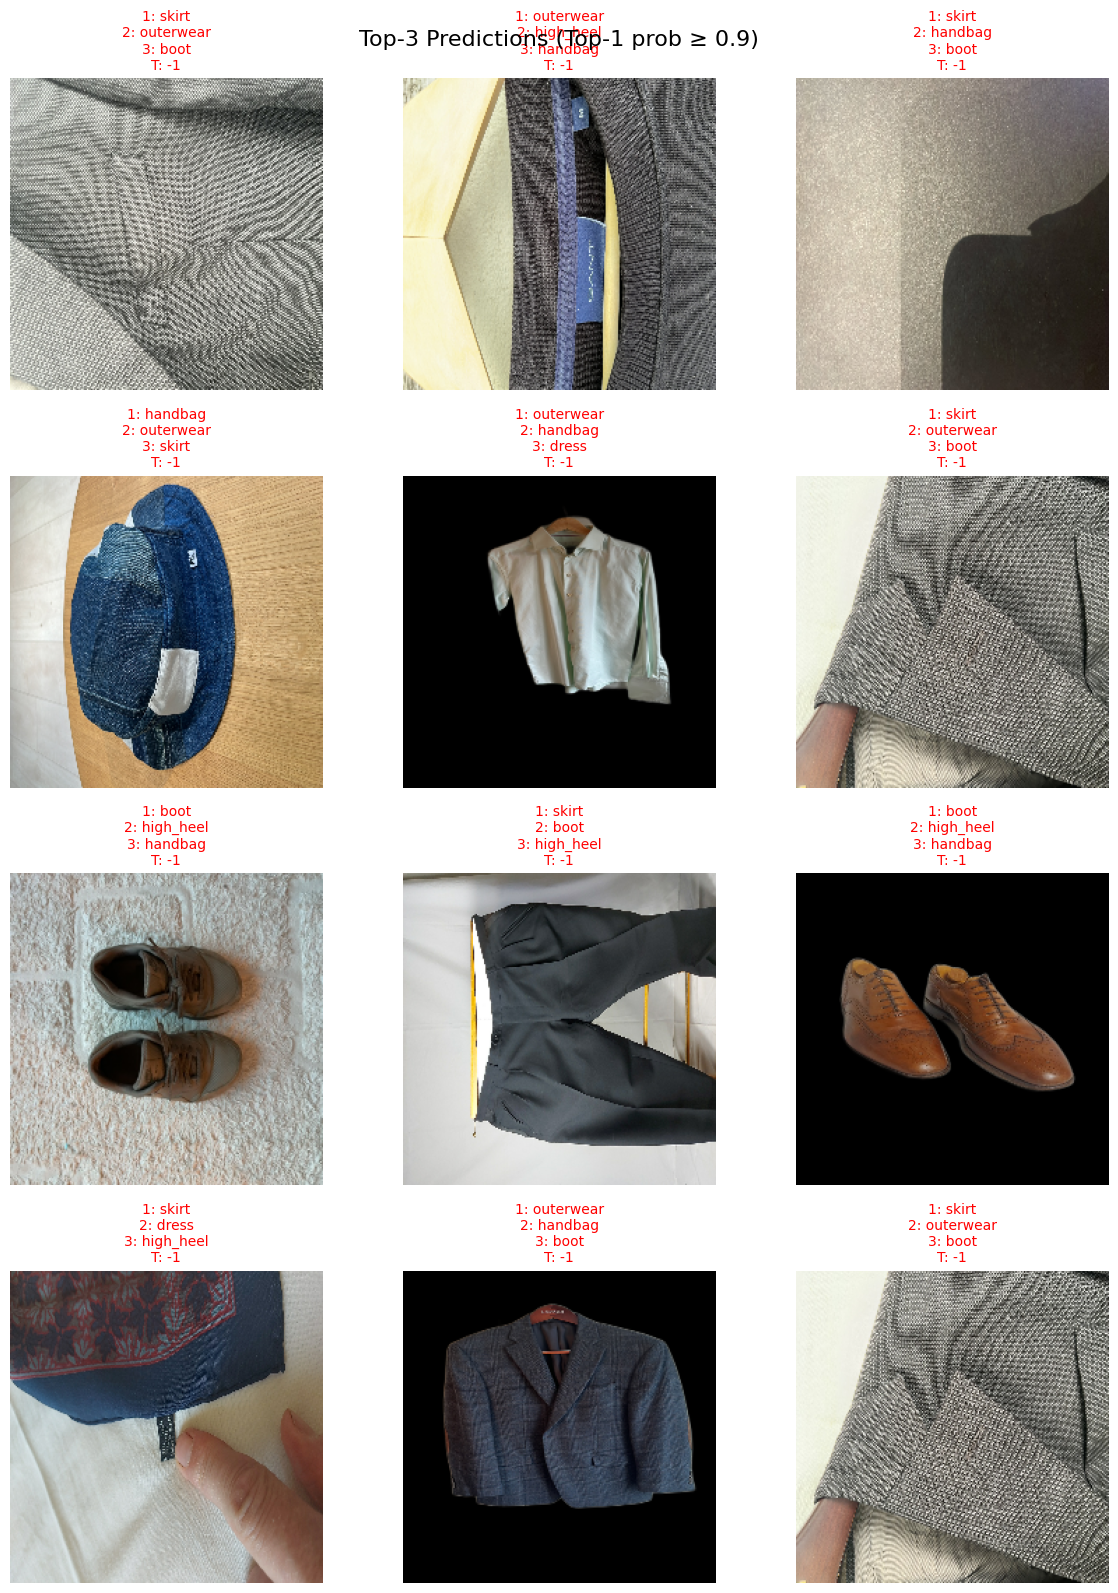

In [64]:
plot_top3_predictions_above_threshold(
    model=mobile_tl_model,
    val_ds=other_val_ds,
    id2label=id2label,
    rows=4,
    cols=3,
    prob_threshold=0.9
)